# **Propensity models for churn (students dropout)**

## **Business context**
###*Study ABC* collaborates with universities to support international students' transition into higher education. To improve student retention, the company leverages data-driven insights to identify at-risk students and predict drop-out risks. By analysing course-level data, *Study ABC* aims to improve academic support, personalise learning pathways, and boost student success rates. This proactive approach helps implement targeted interventions by identifying and predicting students who are more at risk of dropping out, ensuring a more tailored approach to support a smoother educational journey.

## **Objective**
###Advanced machine learning techniques are applied to create a predictive model for student dropout. My work will employ and compare multiple predictive algorithms - **XGBoost** and **Neural Network-based** model, to determine the most effective model for predicting student dropout.

## 🔍**Final Considerations**

###- Both modelling techniques perform well in predicting dropout, with Neural Networks slightly higher on AUC;

###- Choosing the model with the right balance between metrics and generalisation is the recommended choice;

###- Using models parameters, less complexity in the models (lower number of neurons, or less tree depth), in conjunction with a balanced learning rate, tend to generalise better and avoid overfitting;

###- With the use of SHAP clear insights are gathered on the churning students cohort. This information is key to inform and drive *Study ABC* new strategies for students retentions.

## **1.** Importing the required libraries and data set with the provided URL.

In [ ]:
!pip install shap

# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap
from tensorflow import keras
from tensorflow.keras import layers, models
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, classification_report, ConfusionMatrixDisplay, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

seed = 42

## **2.** Read the course-level csv file and make it available as a dataframe.

### **Data**
A dataset of students’ features is used. The data is filtered, processed, transformed and analysed. Models are compared using a filtered table that excludes ContactHours and AttendancePercentage, and a new table including them.

In [ ]:
# Read the CSV file into a new DataFrame.
customer_data = pd.read_csv('/content/CUSTOMERS_data.csv')

df=customer_data.copy()

In [ ]:
# Check for duplicates
duplicate_count = df.duplicated().sum()

print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 0


There are no duplicates in the original dataset so we keep all the observations.

## **3.** Data preparation and EDA.

For now I am still keeping the two extra variables that we have to add later on to the models 'ContactHours',	'AttendancePercentage'

In [ ]:
# List of columns to remove
columns_to_remove = ['BookingId', 'BookingType', 'LeadSource', 'DiscountType', 'Nationality', 'HomeCountry', 'HomeState', 'HomeCity', 'PresentCount', 'LateCount', 'AuthorisedAbsenceCount', 'ArrivedDate', 'NonCompletionReason', 'TerminationDate', 'CourseFirstIntakeDate', 'CourseStartDate', 'CourseEndDate', 'AcademicYear', 'CourseName', 'LearnerCode', 'ProgressionDegree', 'EligibleToProgress', 'AssessedModules', 'PassedModules', 'FailedModules']

df = df.drop(columns=columns_to_remove)
df.head()

,CentreName,DateofBirth,Gender,CourseLevel,IsFirstIntake,CompletedCourse,CreditWeightedAverage,ProgressionUniversity,UnauthorisedAbsenceCount,ContactHours,AttendancePercentage
0,ISC_Aberdeen,13/01/1998,Male,Pre-Masters,True,Yes,75.0,University of Aberdeen,NaN,NaN,NaN
1,ISC_Aberdeen,12/02/1998,Male,Foundation,False,Yes,73.0,University of Aberdeen,5.0,215.0,97.0
2,ISC_Aberdeen,07/04/2000,Male,International Year Two,False,Yes,66.0,University of Aberdeen,6.0,226.0,97.0
3,ISC_Aberdeen,18/05/1999,Male,International Year Two,True,Yes,71.0,University of Aberdeen,15.0,399.0,94.0
4,ISC_Aberdeen,19/04/1996,Male,Pre-Masters,True,Yes,60.0,University of Aberdeen,NaN,NaN,NaN


**Renaming variables values to simplify data read**

In [ ]:
# Remove the prefix 'ISC_' from the 'name' column
df['CentreName'] = df['CentreName'].str.replace('ISC_', '', regex=False)

In [ ]:
# Define a mapping of old values to new values
rename_map = {
'Foundation': 'FND',
'Pre-Masters': 'PRM',
'International Year One': 'IYO',
'International Year Two': 'IYT'
}
df['CourseLevel'] = df['CourseLevel'].replace(rename_map)

In [ ]:
# Define a mapping of old values to new values
rename_map = {
'University of Sheffield International College': 'USI',
'Durham University': 'DUU',
'University of Sussex': 'USS',
'Kingston University London': 'KUL',
'University of Huddersfield': 'UHU',
'University of Leeds': 'ULE',
'Lancaster University': 'LAU',
'University of Surrey': 'USR',
'Royal Holloway': 'RHO',
'Liverpool John Moores University': 'LMU',
'Coventry University London': 'CUL',
'Leeds Beckett University': 'LBU',
'Cardiff University': 'CAU',
'University of Strathclyde': 'UST',
'Teesside University': 'TEU',
'University College Dublin': 'UCD',
'University of Aberdeen': 'UAB',
'University of Lincoln': 'ULI',
'Holland ISC - VU Amsterdam': 'HVA',
'Holland ISC - Tilburg University': 'HTU',
'Holland ISC - Erasmus University Rotterdam': 'HUR',
'VU Amsterdam': 'VUA',
'Holland ISC - Hanze UAS': 'HHU',
'Tilburg University': 'TIU',
'Erasmus Rotterdam': 'ERO',
'Hanze UAS': 'HAU',
'UK Online Pathways': 'UOP',
'Strathclyde University': 'STU',
'Holland ISC - Erasmus University Rotterdam/ Holland ISC - Tilburg University': 'HET',
'Outside of partnership': 'OOP',
'Holland ISC - Erasmus University Rotterdam/Holland ISC - VU Amsterdam': 'HEA',
'Holland ISC - Erasmus University Rotterdam/ Tilburg University': 'HER',
'HULT Business School': 'HBS',
'Holland ISC - Erasmus University Rotterdam/Tilburg University': 'HER',
'Coventry University': 'COU',
'Holland ISC - Hanze UAS/VU Amsterdam': 'HHA',
'Keele University': 'KEU',
'Holland ISC - Tilburg University/VU Amsterdam/Hanze': 'HTA',
'Holland ISC - Erasmus University Rotterdam/Holland ISC - Tilburg University': 'HEH',
'Holland ISC - VU Amsterdam/ Military service': 'HVM'
}

df['ProgressionUniversity'] = df['ProgressionUniversity'].replace(rename_map)

**Converting DateofBirth to Age**

In [ ]:
df['DateofBirth'] = pd.to_datetime(df['DateofBirth'], format='%d/%m/%Y')
today = pd.Timestamp.today()
df['Age'] = (today - df['DateofBirth']).dt.days // 365
df = df.drop(columns=['DateofBirth'])

**Checking missing values**

In [ ]:
# Find missing values.
missings_count = df.isnull().sum()

print(f'Missing values: {missings_count}')
print(df.shape)

Missing values: CentreName                     0
Gender                         0
CourseLevel                    0
IsFirstIntake                  0
CompletedCourse                0
CreditWeightedAverage       2296
ProgressionUniversity          0
UnauthorisedAbsenceCount     208
ContactHours                 208
AttendancePercentage         208
Age                            0
dtype: int64
(25059, 11)


🔍 The data shows that the two extra variables (ContactHours and AttendancePercentage) have the same number of missing values as UnauthorisedAbsenceCount. By checking the overlap in missing value I can establish if they all held missing data and if, by cleaning the 208 NAs from one variable, this will remove also the NAs on the other two:

In [ ]:
missing_overlap = df[['UnauthorisedAbsenceCount', 'ContactHours', 'AttendancePercentage']].isna().all(axis=1)
overlap_count = missing_overlap.sum()
print(f'Number of rows where all three columns have missing values: {overlap_count}')

Number of rows where all three columns have missing values: 208


💡 Upon request of the business I remove any observation that has any missing value: the code shows that the three variables have all missing values on the same rows, they overlap, so we can remove with confidence the NAs across all of them without impacting the number of rows if we were to chose only UnauthorisedAbsenceCount.

**Removing missing values**

In [ ]:
# Find missing values.
missings_count = df.isnull().sum()

**💡Applying One Hot Encoding on categorical variables**: CentreName, Gender, CourseLevel, IsFirstIntake, ProgressionUniversity

In [ ]:
## Renaming variables first to reduce lables strings
new_column_names = {
'CentreName': 'CEN',
'Gender': 'GND',
'CourseLevel': 'CRL',
'IsFirstIntake': 'IFI',
'CompletedCourse': 'COC',
'CreditWeightedAverage': 'CWA',
'ProgressionUniversity': 'PRU',
'UnauthorisedAbsenceCount': 'UAC',
'ContactHours': 'COH',
'AttendancePercentage': 'ATP',
'Age': 'Age'
}

df.rename(columns=new_column_names, inplace=True)

In [ ]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['CEN', 'GND', 'CRL', 'IFI', 'PRU'], drop_first=True)
df_encoded.columns = df_encoded.columns.str.lower()
df_encoded = df_encoded.astype(float)
df_encoded.head()

,cwa,uac,coh,atp,age,target,cen_cardiff,cen_dublin,cen_durham,cen_holland,...,pru_ucd,pru_uhu,pru_ule,pru_uli,pru_uop,pru_usi,pru_usr,pru_uss,pru_ust,pru_vua
1,73.0,5.0,215.0,97.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66.0,6.0,226.0,97.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71.0,15.0,399.0,94.0,25.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,78.0,3.0,371.0,99.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,68.0,25.0,214.0,86.0,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Checking target variable distribution**

In [ ]:
total_counts = df['CompletedCourse'].value_counts()
percentage_counts = df['CompletedCourse'].value_counts(normalize=True) * 100

Converting target variable to binary. Student dropout is the target so we encode CompletedCourse and any "No" is the target for dropout.




In [ ]:
df['target'] = df['CompletedCourse'].apply(lambda x: 1 if x == 'No' else 0)
df = df.drop(columns=['CompletedCourse'])
total_counts = df['target'].value_counts()
percentage_counts = df['target'].value_counts(normalize=True) * 100

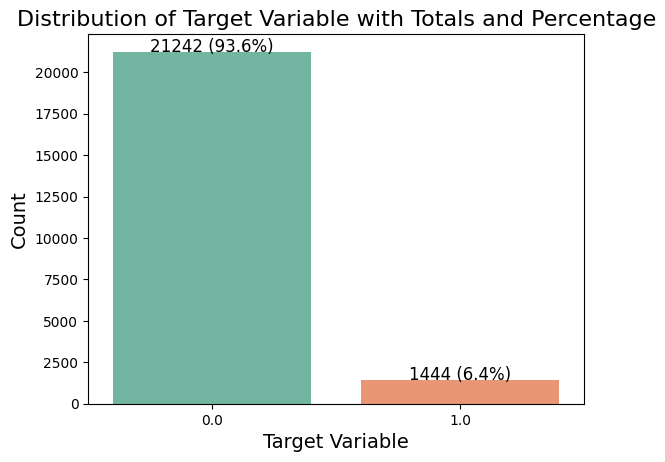

In [ ]:
sns.set_palette("pastel")
sns.countplot(x='target', data=df_encoded, palette='Set2')
total_counts = df_encoded['target'].value_counts()
total = total_counts.sum()
percentages = (total_counts / total) * 100

plt.title('Distribution of Target Variable with Totals and Percentage', fontsize=16)
plt.xlabel('Target Variable', fontsize=14)
plt.ylabel('Count', fontsize=14)

for i, (count, percentage) in enumerate(zip(total_counts, percentages)):
    plt.text(i, count + 0.5, f'{count} ({percentage:.1f}%)', ha='center', fontsize=12)

plt.show()

🔍 The target variable looks fairly imbalanced with 6.4% total drop-outs to be predicted over the total sample.

###**Exploratory Data Analysis**

In [ ]:
df.describe()

,CWA,UAC,COH,ATP,Age,target
count,22686.000000,22686.000000,22686.000000,22686.000000,22686.000000,22686.000000
mean,62.794940,37.692498,394.387199,84.847263,23.776779,0.063652
std,19.324465,37.176733,106.447228,15.625485,3.202377,0.244137
min,0.000000,0.000000,44.000000,1.000000,18.000000,0.000000
25%,60.000000,11.000000,334.000000,80.000000,22.000000,0.000000
50%,67.000000,27.000000,398.000000,89.000000,23.000000,0.000000
75%,74.000000,52.000000,483.000000,96.000000,26.000000,0.000000
max,98.000000,343.000000,792.000000,100.000000,62.000000,1.000000


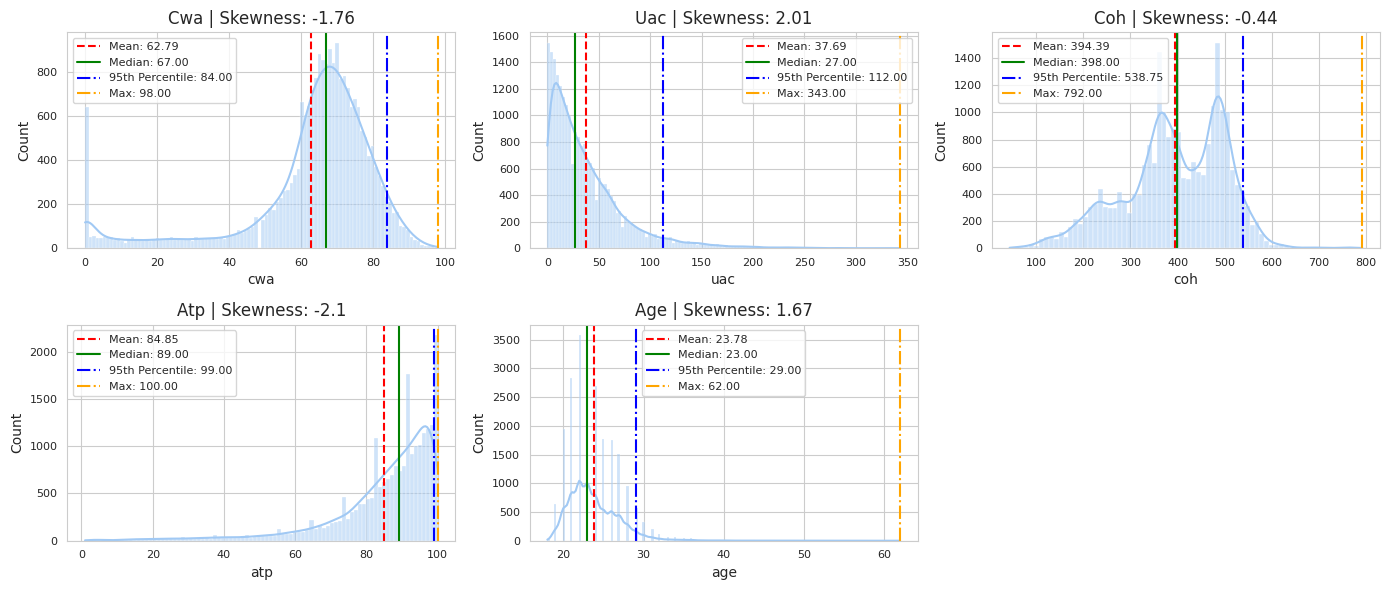

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=8)

num_cols = 3
num_rows = (len(selected_features) + 1) // num_cols

plt.figure(figsize=(14, num_rows * 3))

for idx, feature in enumerate(selected_features, 1):
    plt.subplot(num_rows, num_cols, idx)

    sns.histplot(df_encoded[feature], kde=True)

    # Calculating statistics
    mean_val = df_encoded[feature].mean()
    median_val = df_encoded[feature].median()
    perc_95th = np.percentile(df_encoded[feature], 95)
    max_val = df_encoded[feature].max()

    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    plt.axvline(perc_95th, color='blue', linestyle='-.', label=f'95th Percentile: {perc_95th:.2f}')
    plt.axvline(max_val, color='orange', linestyle='-.', label=f'Max: {max_val:.2f}')

    plt.title(f"{feature.capitalize()} | Skewness: {round(df_encoded[feature].skew(), 2)}")
    plt.legend()

plt.tight_layout()
plt.show()

🔍 There is some skewness in the data with a few numeric features having more extreme values.

### **Plot boxplots of the input features, grouped by target variable.**

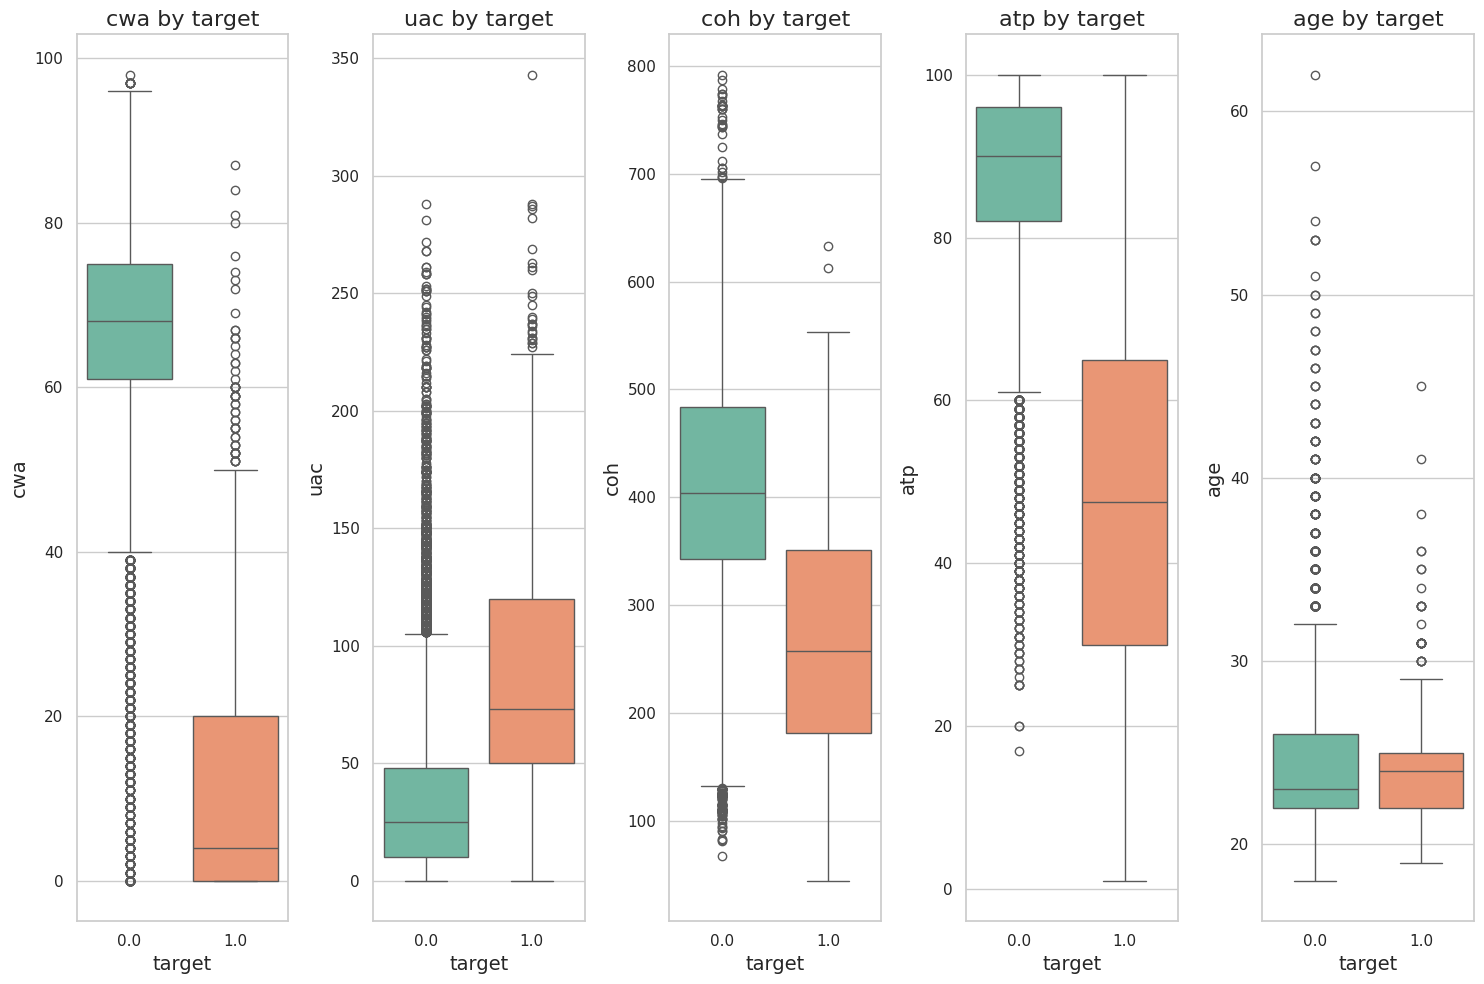

In [ ]:
sns.set(style="whitegrid")

selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']
target_variable = 'target'

num_features = len(selected_features)
num_rows = int(num_features / 5) + (num_features % 5 > 0)
num_cols = 5

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=target_variable, y=feature, data=df_encoded, palette="Set2")
    plt.title(f'{feature} by {target_variable}', fontsize=16)
    plt.xlabel(target_variable, fontsize=14)
    plt.ylabel(feature, fontsize=14)

plt.tight_layout()
plt.show()

💡 Upon inspecting the more extreme values, the data looks genuine, so I decide to keep all observations. These can always be validated with the business to obtain a better context if need to remove.

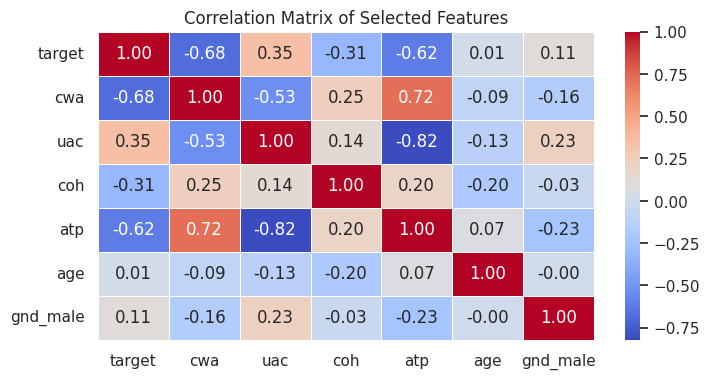

In [ ]:
selected_features = ['target','cwa', 'uac', 'coh', 'atp', 'age', 'gnd_male']
correlation_data = df_encoded[selected_features]
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix of Selected Features', fontsize=12)

plt.show()

🔍 As a preliminary analysis of possible drivers of churn, the boxplots and correlation matrix indicate that certain variables, like CreditWeightedAverage (cwa) and AttendancePercentage (atp), are negatively correlated with dropout, meaning higher scores reduce the likelihood of dropout. In contrast, UnauthorisedAbsenceCount (uac) shows a positive correlation with dropout:

##**Computing train and test samples and scaling the data**

The data is split into three samples: train (for models training), validation (for validation), test (for final predictions and performance).

In [ ]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [ ]:
# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, stratify=y, random_state=seed)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2, shuffle=True, stratify=y_train, random_state=seed)

In [ ]:
def display_counts_and_percentages(y_data, data_name):
    counts = y_data.value_counts()
    percentages = y_data.value_counts(normalize=True) * 100

    df_output = pd.DataFrame({
        f'{data_name} Counts': counts,
        f'{data_name} Percentages (%)': percentages
    })

    return df_output

train_table = display_counts_and_percentages(y_train, "Training Set")
test_table = display_counts_and_percentages(y_test, "Test Set")
val_table = display_counts_and_percentages(y_val, "Val Set")

output_table = pd.concat([train_table, test_table, val_table], axis=1)
output_table

,Training Set Counts,Training Set Percentages (%),Test Set Counts,Test Set Percentages (%),Val Set Counts,Val Set Percentages (%)
target,,,,,,
0.0,13594,93.635487,4249,93.631556,3399,93.636364
1.0,924,6.364513,289,6.368444,231,6.363636


**Check data distribution between samples**

**1) Train sample**

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

X_train_check = pd.DataFrame(X_train, columns=df_encoded.drop('target', axis=1).columns)
X_train_selected = X_train_check[selected_features]
X_train_selected.describe()

,cwa,uac,coh,atp,age
count,14518.000000,14518.000000,14518.000000,14518.000000,14518.000000
mean,62.805276,37.554760,393.952817,84.890550,23.766772
std,19.348720,37.256234,106.232537,15.616757,3.187838
min,0.000000,0.000000,49.000000,1.000000,18.000000
25%,60.000000,11.000000,334.000000,80.000000,22.000000
50%,67.000000,27.000000,398.000000,89.000000,23.000000
75%,74.000000,52.000000,482.000000,96.000000,26.000000
max,97.000000,343.000000,792.000000,100.000000,62.000000


**2) Validation Sample**

In [ ]:
selected_features = ['cwa', 'uac', 'coh', 'atp', 'age']

X_val_check = pd.DataFrame(X_val, columns=df_encoded.drop('target', axis=1).columns)
X_val_selected = X_val_check[selected_features]
X_val_selected.describe()

,cwa,uac,coh,atp,age
count,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,62.824518,36.730579,393.582094,85.000275,23.758402
std,19.196172,35.235094,107.048974,15.499873,3.153076
min,0.000000,0.000000,44.000000,3.000000,18.000000
25%,59.000000,11.000000,333.000000,80.000000,22.000000
50%,67.000000,27.000000,397.000000,89.000000,23.000000
75%,74.000000,51.000000,483.000000,96.000000,26.000000
max,96.000000,287.000000,768.000000,100.000000,51.000000


🔍 Data distribution is fairly similar between the two samples.

### **Transforming the data**

In [ ]:
# Copying the datasets into new df and standardising the features
X_f_train = X_train.copy()
X_f_test = X_test.copy()
X_f_val = X_val.copy()

scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_f_train)
X_test_f_scaled = scaler.transform(X_f_test)
X_val_f_scaled=scaler.transform(X_f_val)

**Dataset for Neural Networks (scaled data):**

X_train_f_scaled

X_test_f_scaled

X_val_f_scaled

**Dataset for XGBoost:**

X_f_train

X_f_test

X_f_val

#**Part 1.** Students drop-out predictive models

###**Performance metrics**


Models results and performance are compared and checked for. Due to target imbalance I chose the following performance metrics over accuracy:

- **Minimised model loss** improves prediction accuracy by measuring the difference between predicted and actual values;

- **F1 score** balances precision and recall, useful for imbalanced classes like dropout detection;

- **Precision** tracks the proportion of correct dropout predictions out of all predicted dropouts;

- **Recall** measures how many actual dropouts are correctly predicted;

- **Model generalisation** to check for the ability in capturing underlying patterns in new data (reduce over/underfitting).

##**Neural Network model**


###📈 Baseline model

###An initial Neural Network baseline model is trained to predict students dropout. Early stopping is also applied.

Here are its distinct **parameters**:

*   Total number of input variables **(63) as neurons**
*   Activation function **ReLU**
*   Optimizer **Adam**
*   **2 hidden layers**

I start with as many neurons as the input variables for hidden layers.



Training model_63_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8332 - loss: 0.4668 - val_accuracy: 0.9694 - val_loss: 0.1133
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.1096 - val_accuracy: 0.9727 - val_loss: 0.0857
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9683 - loss: 0.0857 - val_accuracy: 0.9736 - val_loss: 0.0778
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9705 - loss: 0.0828 - val_accuracy: 0.9730 - val_loss: 0.0828
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9674 - loss: 0.0823 - val_accuracy: 0.9716 - val_loss: 0.0786
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9707 - loss: 0.0765 - val_accuracy: 0.9730 - val_loss: 0.0784
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9685 - loss: 0.0775 - val_accuracy: 0.9733 - val_loss: 0.0753
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9

<Figure size 400x200 with 0 Axes>

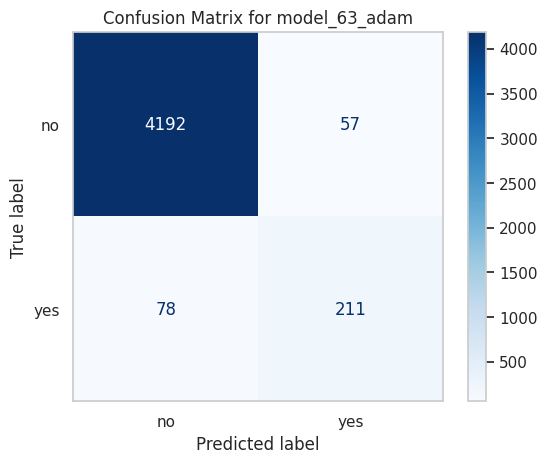

Test AUC for model_63_adam: 0.99


,model_name,train_accuracy,test_accuracy,test_loss,F1_score,precision,recall,AUC
0,model_63_adam,0.9723,0.9703,0.0702,0.9697,0.9694,0.9703,0.9862


In [ ]:
results_list = []

random_seed=seed

# **********  Defining the model architecture   **************
def create_model(hidden_neurons, optimizer, loss='binary_crossentropy', metrics=['accuracy'], l2_reg=None, dropout_rate=None, learning_rate=None):
    model = keras.models.Sequential([
        layers.Input(shape=(X_train_f_scaled.shape[1],)),

        # first hidden layer
        layers.Dense(63, activation='relu'),
        layers.BatchNormalization(),

        # second hidden layer
        layers.Dense(63, activation='relu'),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


model_histories = {}

hidden_neurons = 63
optimizer = 'adam'

model_name = f"model_{hidden_neurons}_{optimizer}"
print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")

# Create an EarlyStopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0,
    restore_best_weights=True,
)

# **********  Creating the model  **************
model = create_model(hidden_neurons=hidden_neurons,
                     optimizer=optimizer,
                     learning_rate=0.001,
                   # l2_reg=0.01, dropout_rate=0.2,
)

# ********** Fitting the model **************
model_history = model.fit(X_train_f_scaled, y_train,
                          epochs=100,
                          batch_size=64,
                          validation_data=(X_val_f_scaled, y_val),
                          callbacks=[early_stopping_callback],
                          verbose=1)


model_histories = {model_name: model_history}
print(f"\n{model_name} has been trained.\n")

epochs_trained = len(model_history.history['loss'])
print(f"Training stopped after {epochs_trained} epochs due to early stopping.\n")


best_train_loss = min(model_history.history['loss'])
best_val_loss = min(model_history.history['val_loss'])
print(f"Best Training Loss: {best_train_loss:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


# ********** Making predictions on the test set (probabilities) **************
y_test_pred = model.predict(X_test_f_scaled)
y_test_pred_classes = (y_test_pred > 0.5).astype("int32")


# ********** Model evaluation **************
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f"{model_name} Test Accuracy: {test_accuracy:.4f}\n")
print(classification_report(y_test, y_test_pred_classes))


# ********** Confusion Matrix **************
cm = confusion_matrix(y_test, y_test_pred_classes)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])

plt.figure(figsize=(4, 2))
cfmd.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix for {model_name}")
plt.show()


# ********** ROC and AUC **************
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"Test AUC for {model_name}: {roc_auc:.2f}")


# ********** Training accuracy and loss **************
train_loss = model_history.history['loss'][-1]
train_accuracy = model_history.history['accuracy'][-1]

test_loss = model.evaluate(X_test_f_scaled, y_test, verbose=0)[0]

# F1 Score, precision, recall
f1_score = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['f1-score']
precision = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['recall']


results_list = [{
    "model_name": model_name,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
    "test_loss": test_loss,
    "F1_score": f1_score,
    "precision": precision,
    "recall": recall,
    "AUC": roc_auc
}]

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

🔍 Fairly strong model results in predicting churn across all the metrics, although there are still a few false positives and false negatives predicted.

**💡 Plotting model loss performance**

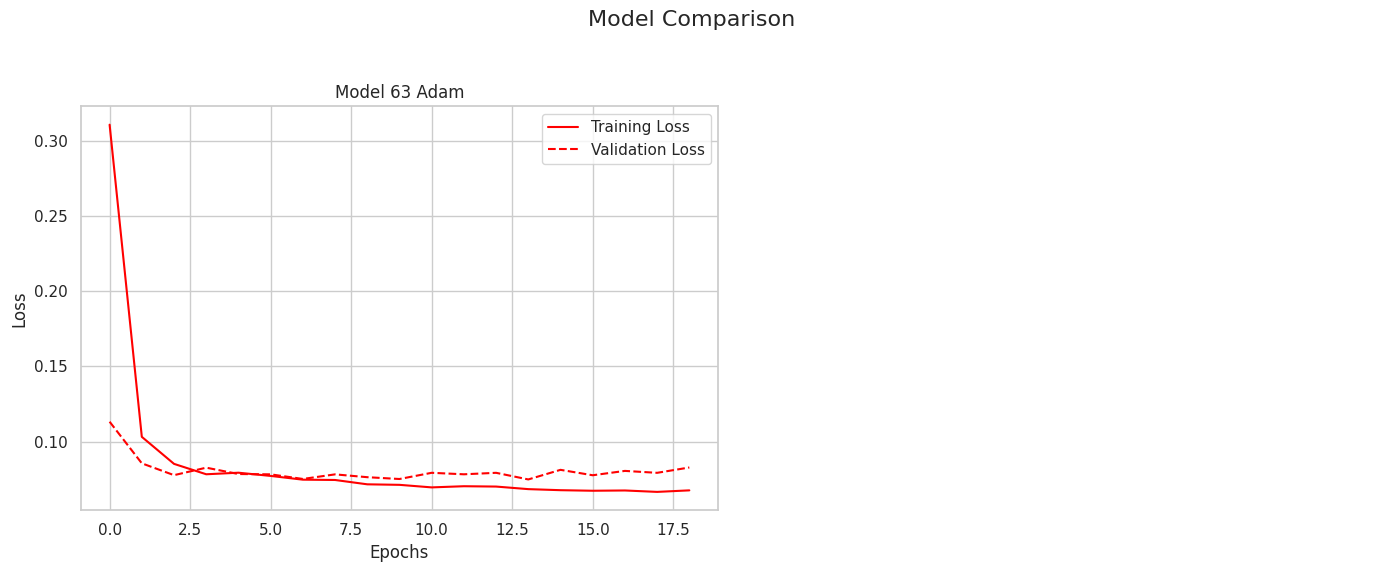

In [ ]:
def plot_model_history(ax, history, title):
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

num_models = len(model_histories)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle('Model Comparison', fontsize=16)

axs = axs.flatten()
for i, (model_name, history) in enumerate(model_histories.items()):
    plot_model_history(axs[i], history, model_name.replace('_', ' ').title())

for j in range(i + 1, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

🔍 The model shows strong results, with around 97% recall, good precision, and F1 score. Some overfitting is evident in the loss curve, as validation loss continues to rise.  

I try hyperparameters tuning to check if model generalisation can improve and if loss can be reduced.

### 📈 **Initial model and Hyperparameters tuning**

**Hyperparameters:**
- reducing number of neurons to **16 and 32**
- optimizers: **adam, rmsprop**
- activation functions: **relu, tanh**

Including also **l2_reg=0.01**, **dropout_rate=0.2** to help with overfitting.



Training model_relu_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7074 - loss: 0.6336 - precision_32: 0.1427 - recall_32: 0.5905 - val_accuracy: 0.9595 - val_loss: 0.2358 - val_precision_32: 0.7234 - val_recall_32: 0.5887
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9593 - loss: 0.1980 - precision_32: 0.6838 - recall_32: 0.7293 - val_accuracy: 0.9711 - val_loss: 0.1118 - val_precision_32: 0.8539 - val_recall_32: 0.6580
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9692 - loss: 0.1058 - precision_32: 0.7874 - recall_32: 0.7015 - val_accuracy: 0.9713 - val_loss: 0.0899 - val_precision_32: 0.8396 - val_recall_32: 0.6797
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9697 - loss: 0.0897 - precision_32: 0.7909 - recall_32: 0.7164 - val_accuracy: 0.9716 - val_loss: 0.0853 - val_precision_32: 0.8855 - val_recall_32: 0.6364
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9682 - 

<Figure size 400x200 with 0 Axes>

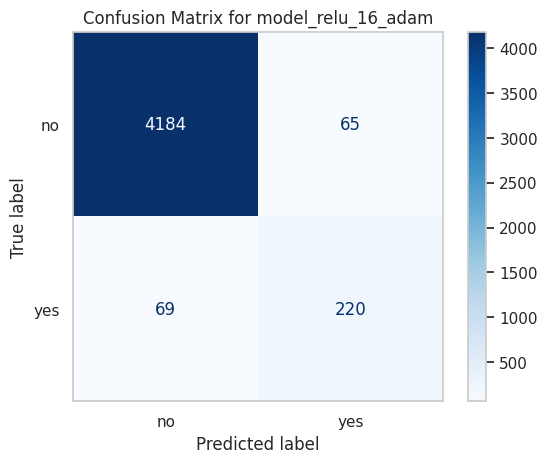

Test AUC for model_relu_16_adam: 0.99


Training model_relu_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6868 - loss: 0.6040 - precision_33: 0.1130 - recall_33: 0.4337 - val_accuracy: 0.9507 - val_loss: 0.2185 - val_precision_33: 0.7889 - val_recall_33: 0.3074
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9529 - loss: 0.1735 - precision_33: 0.6470 - recall_33: 0.5177 - val_accuracy: 0.9617 - val_loss: 0.1059 - val_precision_33: 0.8833 - val_recall_33: 0.4589
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9642 - loss: 0.1004 - precision_33: 0.7567 - recall_33: 0.6328 - val_accuracy: 0.9691 - val_loss: 0.0823 - val_precision_33: 0.8251 - val_recall_33: 0.6537
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0858 - precision_33: 0.7524 - recall_33: 0.6772 - val_accuracy: 0.9722 - val_loss: 0.0810 - val_precision_33: 0.8611 - val_recall_33: 0.6710
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

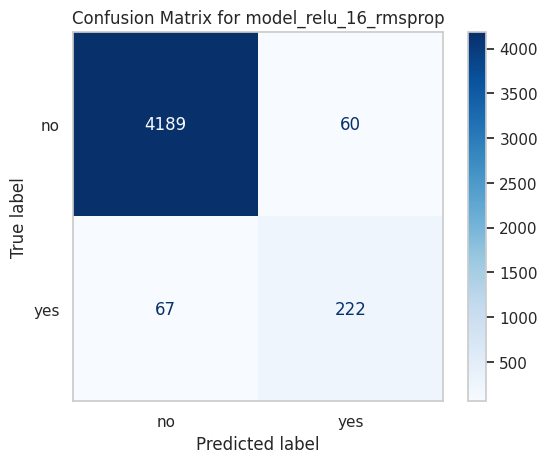

Test AUC for model_relu_16_rmsprop: 0.98


Training model_tanh_16_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7538 - loss: 0.6065 - precision_34: 0.1983 - recall_34: 0.7938 - val_accuracy: 0.9680 - val_loss: 0.1988 - val_precision_34: 0.7778 - val_recall_34: 0.6970
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9638 - loss: 0.1866 - precision_34: 0.7078 - recall_34: 0.7637 - val_accuracy: 0.9713 - val_loss: 0.1001 - val_precision_34: 0.8629 - val_recall_34: 0.6537
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9707 - loss: 0.1008 - precision_34: 0.7842 - recall_34: 0.7254 - val_accuracy: 0.9705 - val_loss: 0.0831 - val_precision_34: 0.8039 - val_recall_34: 0.7100
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9693 - loss: 0.0865 - precision_34: 0.7862 - recall_34: 0.7315 - val_accuracy: 0.9711 - val_loss: 0.0774 - val_precision_34: 0.8214 - val_recall_34: 0.6970
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

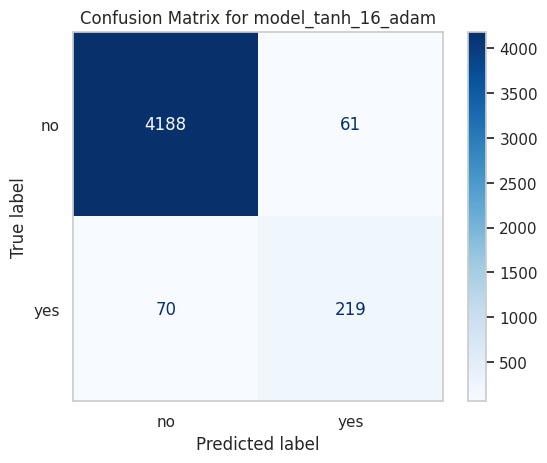

Test AUC for model_tanh_16_adam: 0.99


Training model_tanh_16_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7735 - loss: 0.5539 - precision_35: 0.2183 - recall_35: 0.8094 - val_accuracy: 0.9697 - val_loss: 0.1644 - val_precision_35: 0.8538 - val_recall_35: 0.6320
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9692 - loss: 0.1394 - precision_35: 0.7588 - recall_35: 0.7317 - val_accuracy: 0.9691 - val_loss: 0.0856 - val_precision_35: 0.8251 - val_recall_35: 0.6537
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9702 - loss: 0.0864 - precision_35: 0.7849 - recall_35: 0.6971 - val_accuracy: 0.9702 - val_loss: 0.0799 - val_precision_35: 0.7943 - val_recall_35: 0.7186
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0742 - precision_35: 0.8067 - recall_35: 0.7707 - val_accuracy: 0.9719 - val_loss: 0.0786 - val_precision_35: 0.7972 - val_recall_35: 0.7489
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

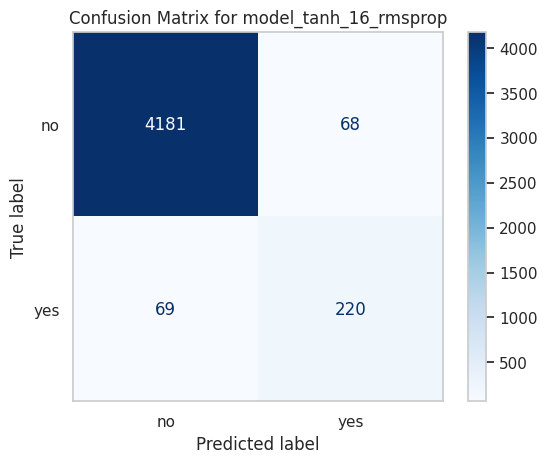

Test AUC for model_tanh_16_rmsprop: 0.98


Training model_relu_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7996 - loss: 0.5402 - precision_36: 0.2353 - recall_36: 0.7765 - val_accuracy: 0.9639 - val_loss: 0.1715 - val_precision_36: 0.8968 - val_recall_36: 0.4892
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9641 - loss: 0.1467 - precision_36: 0.7193 - recall_36: 0.6874 - val_accuracy: 0.9702 - val_loss: 0.0982 - val_precision_36: 0.8596 - val_recall_36: 0.6364
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9696 - loss: 0.0930 - precision_36: 0.7719 - recall_36: 0.6934 - val_accuracy: 0.9716 - val_loss: 0.0896 - val_precision_36: 0.8333 - val_recall_36: 0.6926
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.0832 - precision_36: 0.7740 - recall_36: 0.7202 - val_accuracy: 0.9738 - val_loss: 0.0812 - val_precision_36: 0.8469 - val_recall_36: 0.7186
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

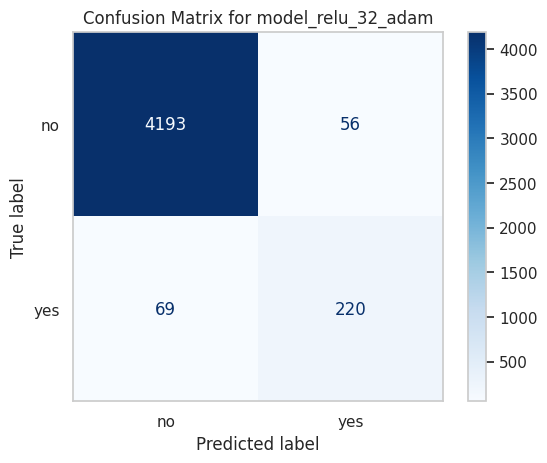

Test AUC for model_relu_32_adam: 0.99


Training model_relu_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7854 - loss: 0.5231 - precision_37: 0.2039 - recall_37: 0.6705 - val_accuracy: 0.9650 - val_loss: 0.1372 - val_precision_37: 0.9062 - val_recall_37: 0.5022
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9642 - loss: 0.1175 - precision_37: 0.7603 - recall_37: 0.6473 - val_accuracy: 0.9689 - val_loss: 0.0885 - val_precision_37: 0.8782 - val_recall_37: 0.5931
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0916 - precision_37: 0.7731 - recall_37: 0.6949 - val_accuracy: 0.9725 - val_loss: 0.0812 - val_precision_37: 0.8359 - val_recall_37: 0.7056
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.0791 - precision_37: 0.7827 - recall_37: 0.7071 - val_accuracy: 0.9727 - val_loss: 0.0827 - val_precision_37: 0.8548 - val_recall_37: 0.6883
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

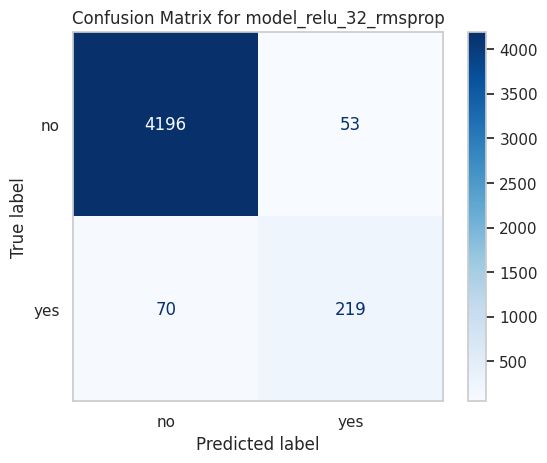

Test AUC for model_relu_32_rmsprop: 0.99


Training model_tanh_32_adam...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7927 - loss: 0.5192 - precision_38: 0.2484 - recall_38: 0.8392 - val_accuracy: 0.9697 - val_loss: 0.1478 - val_precision_38: 0.8418 - val_recall_38: 0.6450
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9675 - loss: 0.1315 - precision_38: 0.7551 - recall_38: 0.7457 - val_accuracy: 0.9702 - val_loss: 0.0890 - val_precision_38: 0.8220 - val_recall_38: 0.6797
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9717 - loss: 0.0842 - precision_38: 0.8110 - recall_38: 0.7452 - val_accuracy: 0.9738 - val_loss: 0.0787 - val_precision_38: 0.8400 - val_recall_38: 0.7273
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9683 - loss: 0.0858 - precision_38: 0.7905 - recall_38: 0.7167 - val_accuracy: 0.9727 - val_loss: 0.0821 - val_precision_38: 0.8084 - val_recall_38: 0.7489
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

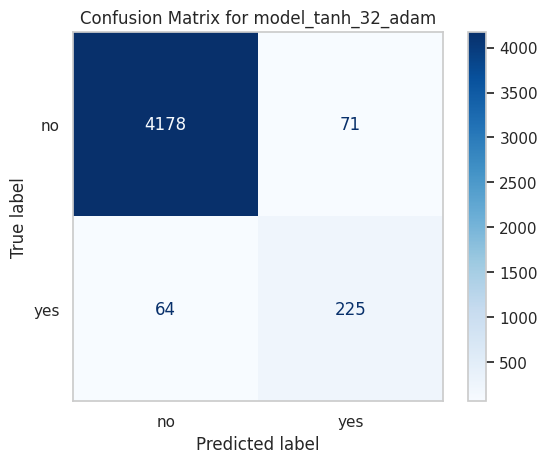

Test AUC for model_tanh_32_adam: 0.98


Training model_tanh_32_rmsprop...

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8248 - loss: 0.4936 - precision_39: 0.2616 - recall_39: 0.8106 - val_accuracy: 0.9697 - val_loss: 0.1109 - val_precision_39: 0.8235 - val_recall_39: 0.6667
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9667 - loss: 0.1027 - precision_39: 0.7569 - recall_39: 0.7065 - val_accuracy: 0.9700 - val_loss: 0.0813 - val_precision_39: 0.7850 - val_recall_39: 0.7273
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9678 - loss: 0.0816 - precision_39: 0.7610 - recall_39: 0.7159 - val_accuracy: 0.9708 - val_loss: 0.0777 - val_precision_39: 0.7990 - val_recall_39: 0.7229
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.0722 - precision_39: 0.7854 - recall_39: 0.7421 - val_accuracy: 0.9713 - val_loss: 0.0751 - val_precision_39: 0.8009 - val_recall_39: 0.7316
Epoch 5/100
227/227 ━━━━━━━━━━━━━

<Figure size 400x200 with 0 Axes>

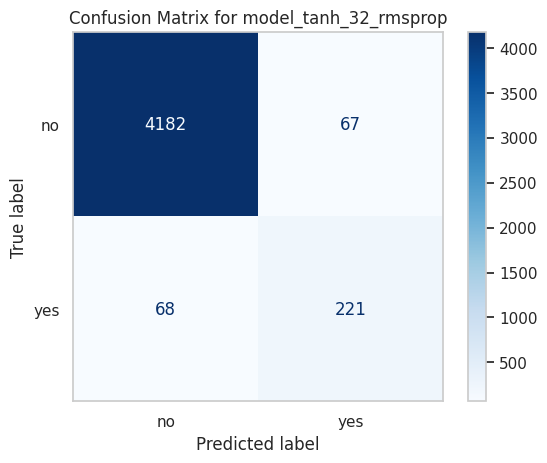

Test AUC for model_tanh_32_rmsprop: 0.98


,model_name,train_accuracy,test_accuracy,test_loss,F1_score,precision,recall,AUC
0,model_relu_16_adam,0.9716,0.9705,0.0709,0.9704,0.9703,0.9705,0.9852
1,model_relu_16_rmsprop,0.9720,0.9720,0.0697,0.9719,0.9717,0.9720,0.9848
2,model_tanh_16_adam,0.9720,0.9711,0.0696,0.9709,0.9707,0.9711,0.9859
3,model_tanh_16_rmsprop,0.9720,0.9698,0.0715,0.9698,0.9698,0.9698,0.9843
4,model_relu_32_adam,0.9724,0.9725,0.0702,0.9722,0.9719,0.9725,0.9856
5,model_relu_32_rmsprop,0.9719,0.9729,0.0695,0.9725,0.9722,0.9729,0.9852
6,model_tanh_32_adam,0.9727,0.9703,0.0725,0.9704,0.9706,0.9703,0.9843
7,model_tanh_32_rmsprop,0.9719,0.9703,0.0711,0.9702,0.9702,0.9703,0.9839


In [ ]:
# List of activation functions
activation_functions = ['relu', 'tanh']

results_list = []

random_seed = seed

def create_model(hidden_neurons, activation, optimizer, loss='binary_crossentropy', metrics=None, l2_reg=None, dropout_rate=None, learning_rate=None):
    model = models.Sequential([
        layers.Input(shape=(X_train_f_scaled.shape[1],)),

        # first hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # second hidden layer
        layers.Dense(hidden_neurons, activation=activation),
        layers.BatchNormalization(),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ])

    if metrics is None:
        metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

#************** Parameters for model training and tuning **********************
hidden_layers_neurons = [16, 32]
activation_functions = ['relu', 'tanh']
optimizers = ['adam', 'rmsprop']

model_histories = {}

for hidden_neurons in hidden_layers_neurons:
    for activation in activation_functions:
        for optimizer in optimizers:
            model_name = f"model_{activation}_{hidden_neurons}_{optimizer}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")

# EarlyStopping callback
            early_stopping_callback = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                min_delta=0,
                restore_best_weights=True,
            )

#************** Creating the model ******************
            model = create_model(hidden_neurons=hidden_neurons,
                                 activation=activation,
                                 optimizer=optimizer,
                                 learning_rate=0.001,
                                 l2_reg=0.01, dropout_rate=0.2
            )

#************** Fitting the model ******************
            model_history = model.fit(X_train_f_scaled, y_train,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(X_val_f_scaled, y_val),
                                      callbacks=[early_stopping_callback],
                                      verbose=1)

            model_histories[model_name] = model_history
            print(f"\n{model_name} has been trained.\n")

            epochs_trained = len(model_history.history['loss'])
            print(f"Training stopped after {epochs_trained} epochs due to early stopping.\n")

            best_train_loss = min(model_history.history['loss'])
            best_val_loss = min(model_history.history['val_loss'])
            print(f"Best Training Loss: {best_train_loss:.4f}")
            print(f"Best Validation Loss: {best_val_loss:.4f}")

#************** Making predictions on the test set (probabilities) ************
            y_test_pred = model.predict(X_test_f_scaled)
            y_test_pred_classes = (y_test_pred > 0.5).astype("int32")

#************** Model evaluation *****************
            test_accuracy = accuracy_score(y_test, y_test_pred_classes)
            print(f"{model_name} Test Accuracy: {test_accuracy:.4f}\n")
            print(classification_report(y_test, y_test_pred_classes))

#************** Confusion Matrix *****************
            cm = confusion_matrix(y_test, y_test_pred_classes)
            cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])

            plt.figure(figsize=(4, 2))
            cfmd.plot(cmap='Blues')
            plt.grid(False)
            plt.title(f"Confusion Matrix for {model_name}")
            plt.show()

#************** ROC and AUC *****************
            fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            print(f"Test AUC for {model_name}: {roc_auc:.2f}")

#************** Training accuracy and loss *****************
            train_loss = model_history.history['loss'][-1]
            train_accuracy = model_history.history['accuracy'][-1]

            test_loss = model.evaluate(X_test_f_scaled, y_test, verbose=0)[0]

# F1 Score, precision, recall
            f1_score = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['f1-score']
            precision = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['precision']
            recall = classification_report(y_test, y_test_pred_classes, output_dict=True)['weighted avg']['recall']

            results_list.append({
                "model_name": model_name,
                "train_accuracy": train_accuracy,
                "test_accuracy": test_accuracy,
                "test_loss": test_loss,
                "F1_score": f1_score,
                "precision": precision,
                "recall": recall,
                "AUC": roc_auc
            })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)
summary_df

**💡Plotting Models loss performance for comparison**

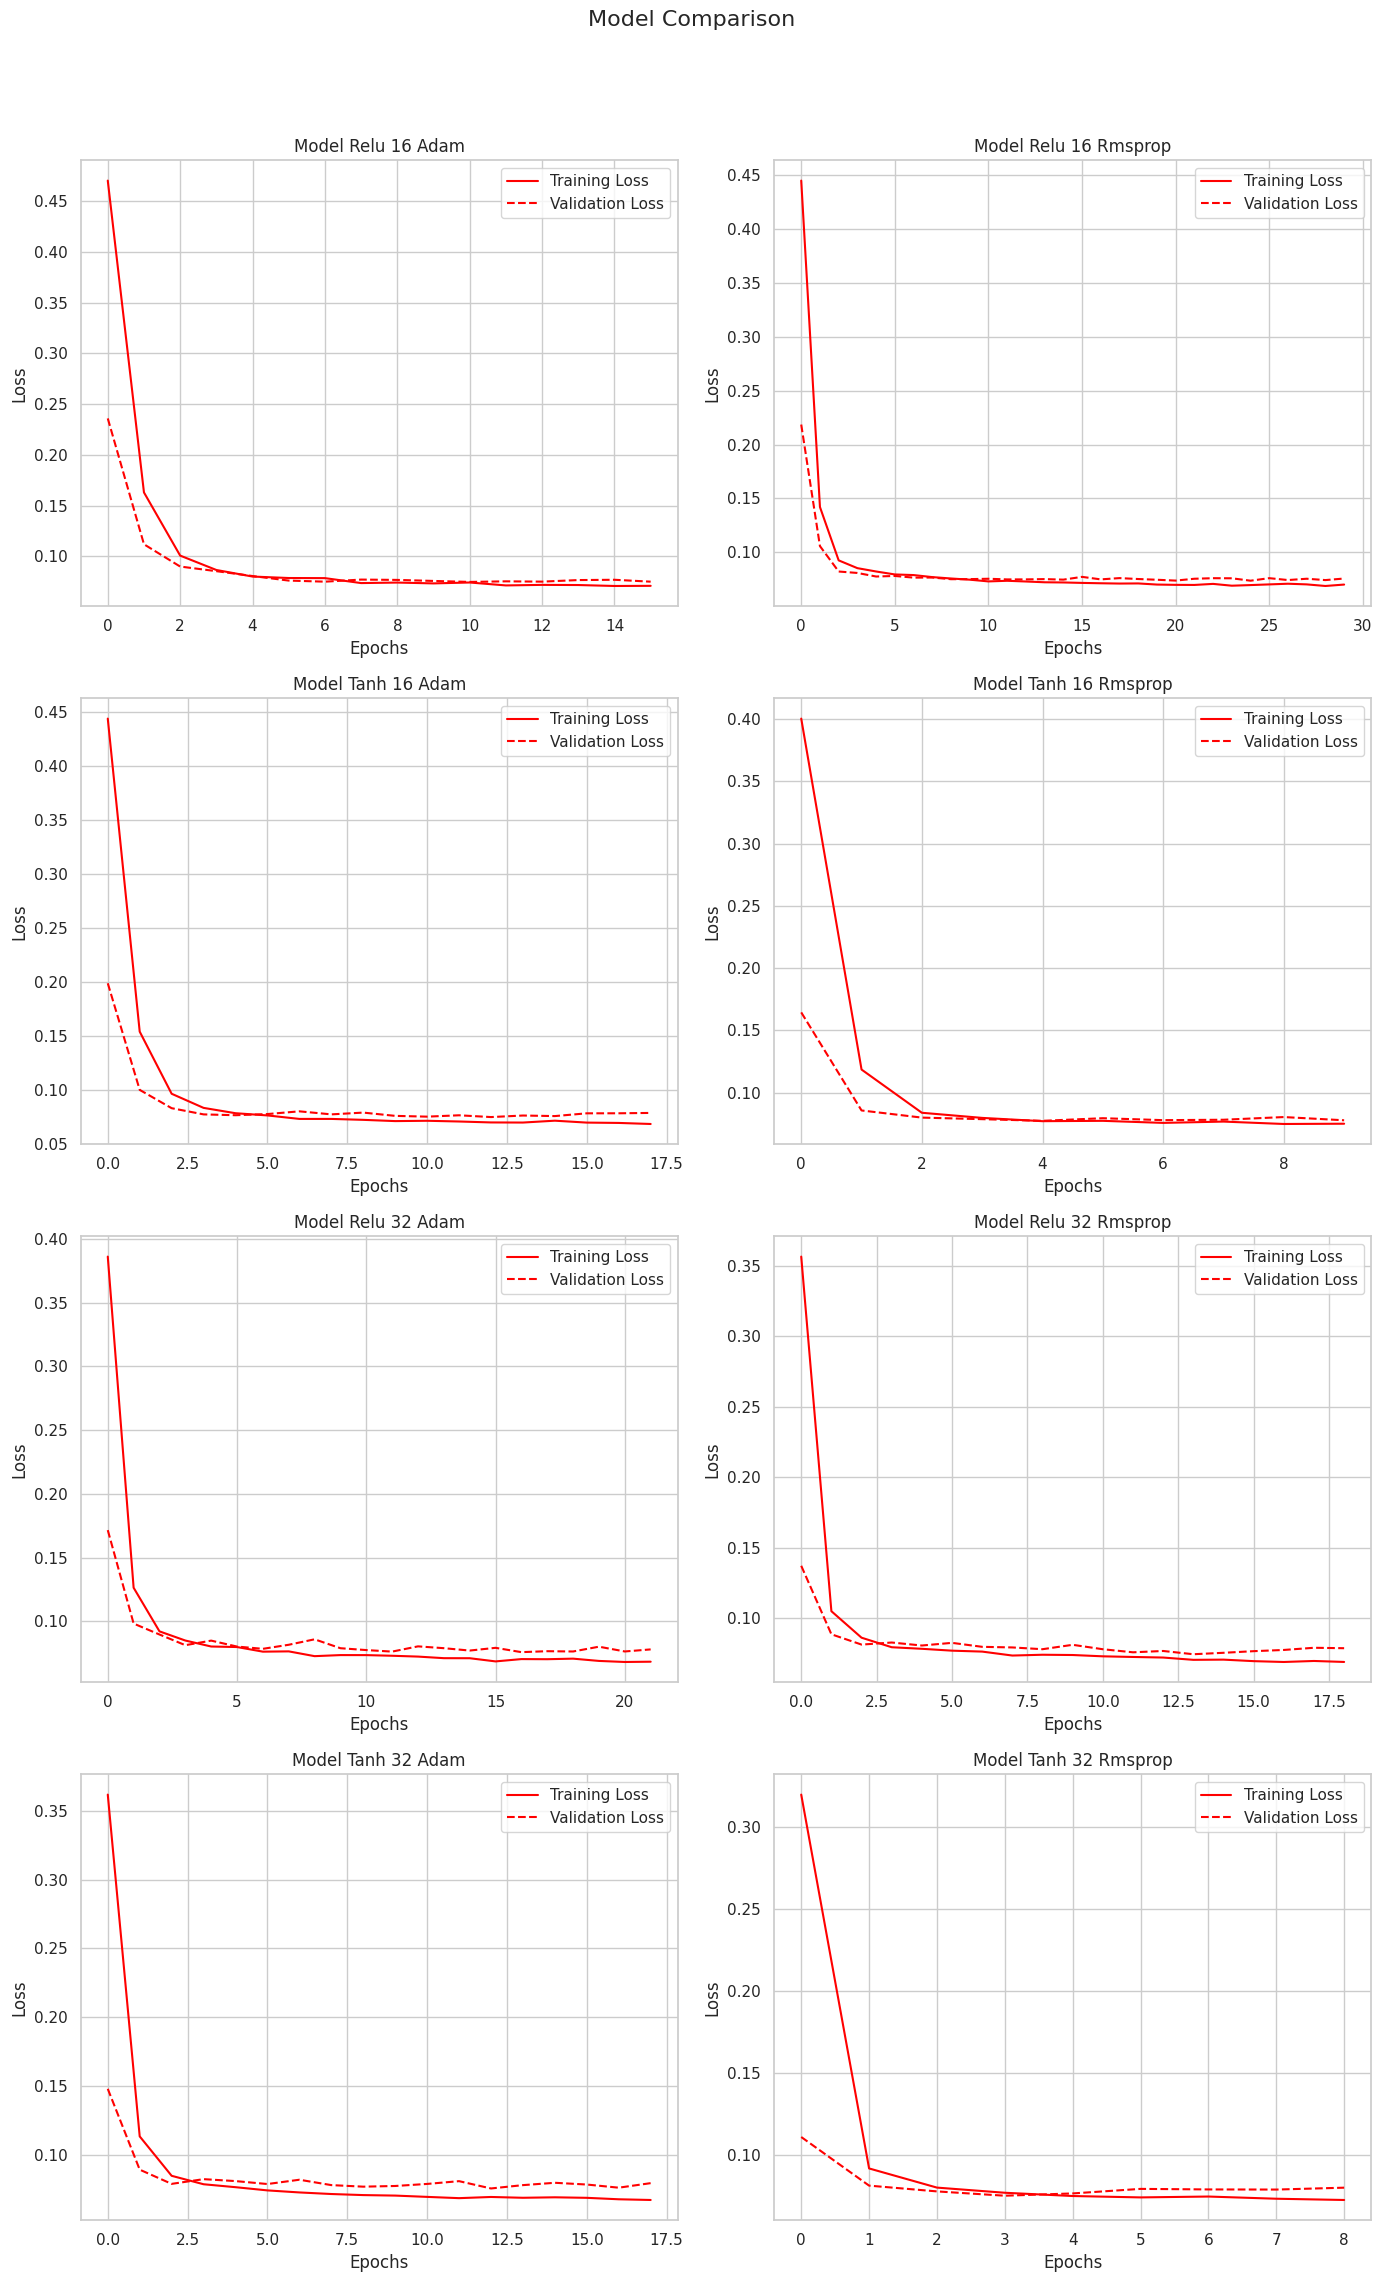

In [ ]:
def plot_model_history(ax, history, title):
    ax.plot(history.history['loss'], label='Training Loss', color='red')
    ax.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

num_models = len(model_histories)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
fig.suptitle('Model Comparison', fontsize=16)

axs = axs.flatten()

for i, (model_name, history) in enumerate(model_histories.items()):
    plot_model_history(axs[i], history, model_name.replace('_', ' ').title())

for j in range(i + 1, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Models results summary table**

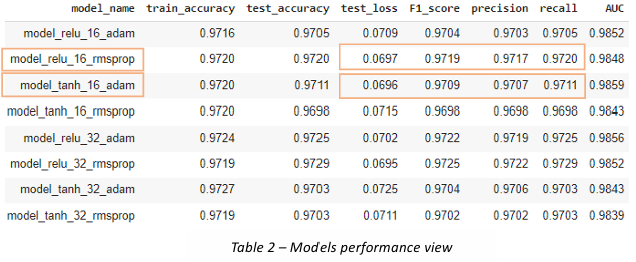

🔍 The results vary between model, however two models (ReLU 16nn Rmsprop and Tanh 16nn Adam) outperform others, showing improved loss, F1, precision, and recall on the test set compared to the baseline model. The loss curves indicate better alignment between training and validation, suggesting these are well-balanced models.

##**XGBoost Model**

###📈 Baseline model.

In [ ]:
# XGBoost Classifier
xgb_model = XGBClassifier(objective='binary:logistic',
                eval_metric = 'logloss',
                early_stopping_rounds=50,
                random_state=seed
)

In [ ]:
random_seed=seed
# Fitting the model with evaluation metric (logloss) for train and test
xgb_model.fit(X_f_train, y_train, eval_set=[(X_f_train, y_train), (X_f_test, y_test)], verbose=0)

XGBoost Model Test Accuracy:  0.9724548259144998
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.80      0.76      0.78       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

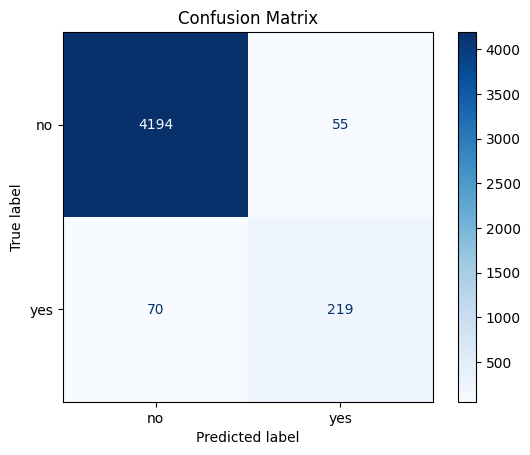

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgb_model,0.9787,0.9725,0.0339,0.0761,0.9721,0.9718,0.9725,0.8724


In [ ]:
random_seed=seed
model_name = "xgb_model"

results_list = []

# ***************************** Predictions ******************************
train_pred = xgb_model.predict(X_f_train)
test_pred = xgb_model.predict(X_f_test)

# ***************************** Train and Test evaluations *****************
results = xgb_model.evals_result()
train_loss = results['validation_0']['logloss'][-1]
test_loss = results['validation_1']['logloss'][-1]

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

f1_test = f1_score(y_test, test_pred, average='weighted')
precision = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['precision']
recall = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['recall']

auc_test = roc_auc_score(y_test, test_pred)

print("XGBoost Model Test Accuracy: ", test_accuracy)
print(classification_report(y_test, test_pred))

#****************************** Confusion Matrix and Plot *********************
cm = confusion_matrix(y_test, test_pred)
cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no","yes"])
plt.figure(figsize=(4, 2))
cfmd.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

results_list.append({
"model_name": model_name,
"train_accuracy": train_accuracy,
"test_accuracy": test_accuracy,
"train_loss": train_loss,
"test_loss": test_loss,
"F1_score": f1_test,
"precision": precision,
"recall": recall,
"AUC": auc_test
            })
summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

🔍  The model shows strong recall (97%), precision, and F1 score, though some overfitting is observed between train and test loss.  

**💡 Hyperparameter tuning** via grid search is used to reduce loss and overfitting by testing different combinations of **learning rates (0.1, 0.01)**, **estimators (100, 500)**, and **max depth (4, 8)**.

### 📈 **Hyperparameters tuning**

**Initiating the models**

In [ ]:
#************************** Defining the parameters *************************
learning_rate = [0.1, 0.01]
n_estimators = [100, 500]   # Number of trees
max_depth = [4, 8]          # Maximum depth of each tree

random_state=seed

model_counter = 1

xgb_models = {}

# Grid search
for lr in learning_rate:
    for n_est in n_estimators:
        for depth in max_depth:
            model_name = f"xgbmodel_{lr}_{n_est}_{depth}"
            print(f"\n\n{'='*50}\nTraining {model_name}...\n{'='*50}\n")
            xgb_models[model_name] = XGBClassifier(
                objective='binary:logistic',
                eval_metric = 'logloss',
                learning_rate=lr,
                n_estimators=n_est,
                max_depth=depth,
                early_stopping_rounds=50,
                random_state=seed
            )
            print(f"{model_name} created with learning_rate={lr}, n_estimators={n_est}, max_depth={depth}")
            model_counter += 1



Training xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 created with learning_rate=0.1, n_estimators=100, max_depth=4


Training xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 created with learning_rate=0.1, n_estimators=100, max_depth=8


Training xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 created with learning_rate=0.1, n_estimators=500, max_depth=4


Training xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 created with learning_rate=0.1, n_estimators=500, max_depth=8


Training xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 created with learning_rate=0.01, n_estimators=100, max_depth=4


Training xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 created with learning_rate=0.01, n_estimators=100, max_depth=8


Training xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 created with learning_rate=0.01, n_estimators=500, max_depth=4


Training xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 created with learning_rate=0.01, n_estimators=500, max_depth=8


**Fitting the models**

In [ ]:
random_state=seed

model_histories = {}

for model_name, model in xgb_models.items():
    print(f"Training {model_name}...")

    model.fit(X_f_train, y_train, eval_set=[(X_f_train, y_train), (X_f_test, y_test)], verbose=0)
    print(f"{model_name} has been trained.\n")

Training xgbmodel_0.1_100_4...
xgbmodel_0.1_100_4 has been trained.

Training xgbmodel_0.1_100_8...
xgbmodel_0.1_100_8 has been trained.

Training xgbmodel_0.1_500_4...
xgbmodel_0.1_500_4 has been trained.

Training xgbmodel_0.1_500_8...
xgbmodel_0.1_500_8 has been trained.

Training xgbmodel_0.01_100_4...
xgbmodel_0.01_100_4 has been trained.

Training xgbmodel_0.01_100_8...
xgbmodel_0.01_100_8 has been trained.

Training xgbmodel_0.01_500_4...
xgbmodel_0.01_500_4 has been trained.

Training xgbmodel_0.01_500_8...
xgbmodel_0.01_500_8 has been trained.



**Models evaluation**



Evaluating xgbmodel_0.1_100_4...

xgbmodel_0.1_100_4 Test Accuracy: 0.9744
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.83      0.76      0.79       289

    accuracy                           0.97      4538
   macro avg       0.91      0.87      0.89      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

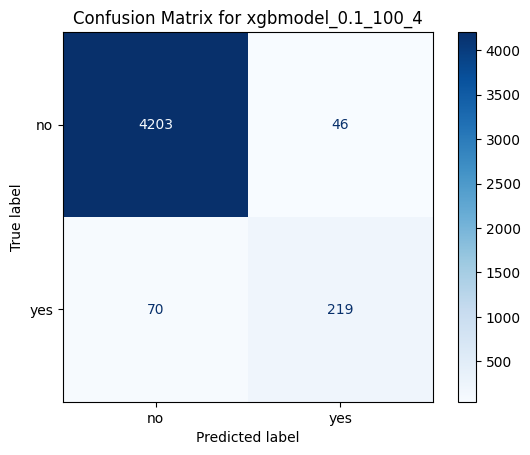



Evaluating xgbmodel_0.1_100_8...

xgbmodel_0.1_100_8 Test Accuracy: 0.9714
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4249
         1.0       0.79      0.74      0.77       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

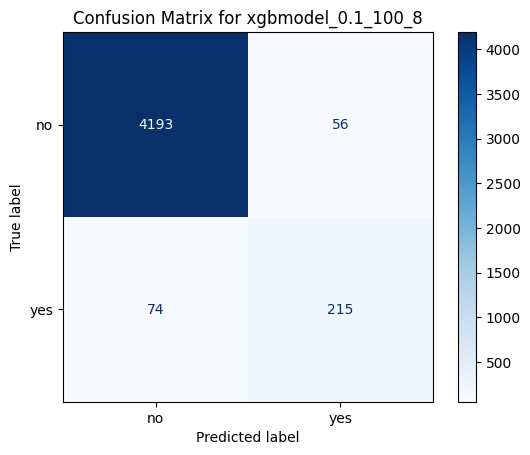



Evaluating xgbmodel_0.1_500_4...

xgbmodel_0.1_500_4 Test Accuracy: 0.9744
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.83      0.76      0.79       289

    accuracy                           0.97      4538
   macro avg       0.91      0.87      0.89      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

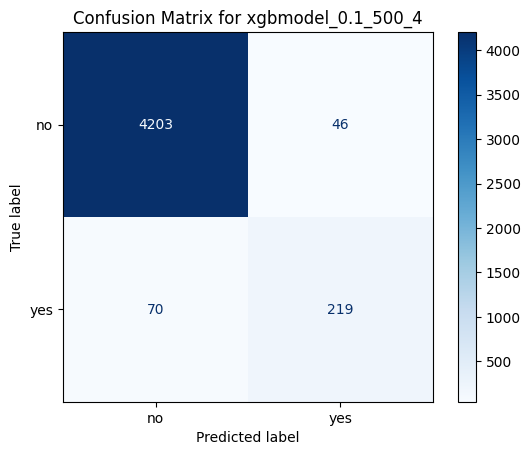



Evaluating xgbmodel_0.1_500_8...

xgbmodel_0.1_500_8 Test Accuracy: 0.9714
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4249
         1.0       0.79      0.74      0.77       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

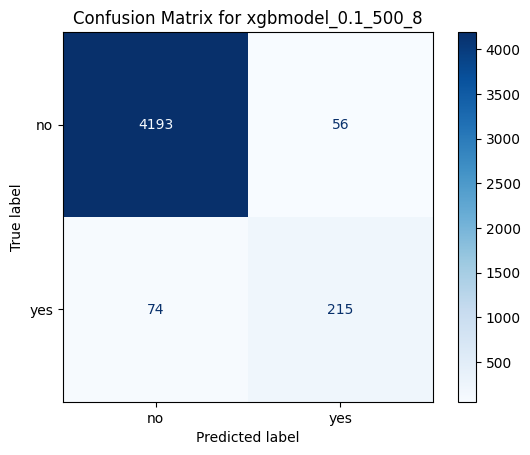



Evaluating xgbmodel_0.01_100_4...

xgbmodel_0.01_100_4 Test Accuracy: 0.9645
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4249
         1.0       0.88      0.51      0.65       289

    accuracy                           0.96      4538
   macro avg       0.92      0.75      0.81      4538
weighted avg       0.96      0.96      0.96      4538



<Figure size 400x200 with 0 Axes>

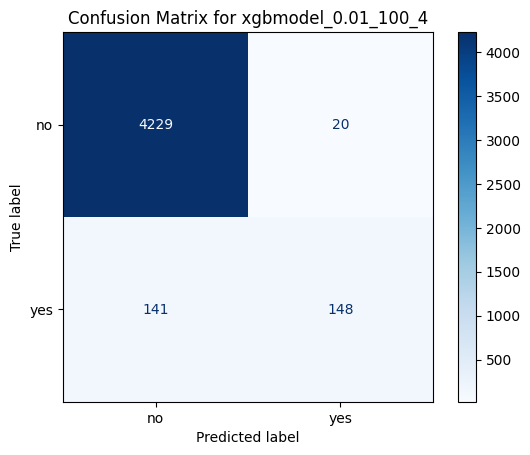



Evaluating xgbmodel_0.01_100_8...

xgbmodel_0.01_100_8 Test Accuracy: 0.9689
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      4249
         1.0       0.89      0.59      0.71       289

    accuracy                           0.97      4538
   macro avg       0.93      0.79      0.85      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

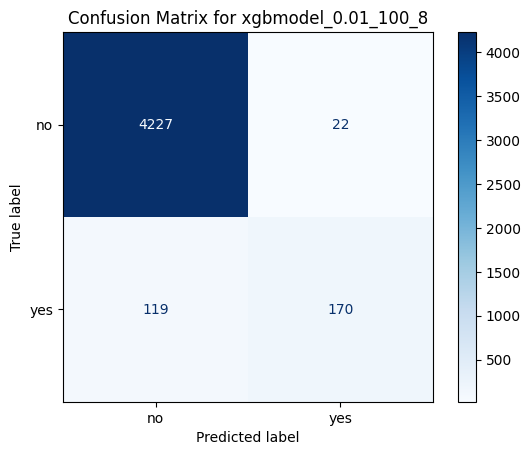



Evaluating xgbmodel_0.01_500_4...

xgbmodel_0.01_500_4 Test Accuracy: 0.9725
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.82      0.73      0.77       289

    accuracy                           0.97      4538
   macro avg       0.90      0.86      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

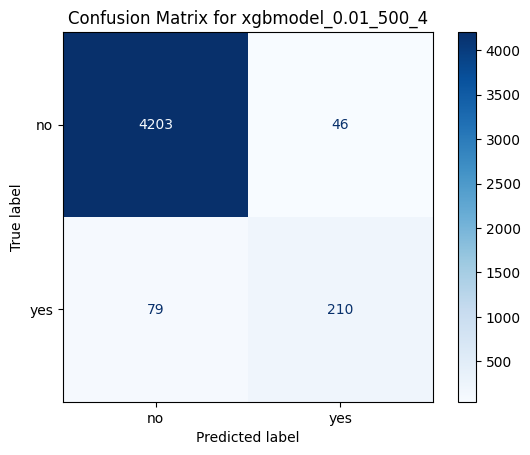



Evaluating xgbmodel_0.01_500_8...

xgbmodel_0.01_500_8 Test Accuracy: 0.9725
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4249
         1.0       0.80      0.75      0.78       289

    accuracy                           0.97      4538
   macro avg       0.89      0.87      0.88      4538
weighted avg       0.97      0.97      0.97      4538



<Figure size 400x200 with 0 Axes>

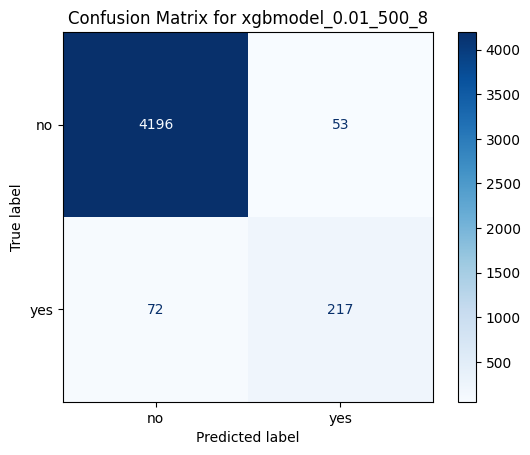

,model_name,train_accuracy,test_accuracy,train_loss,test_loss,F1_score,precision,recall,AUC
0,xgbmodel_0.1_100_4,0.9753,0.9744,0.0582,0.0692,0.9739,0.9736,0.9744,0.8735
1,xgbmodel_0.1_100_8,0.9837,0.9714,0.0371,0.0732,0.9709,0.9706,0.9714,0.8654
2,xgbmodel_0.1_500_4,0.9753,0.9744,0.0549,0.0691,0.9739,0.9736,0.9744,0.8735
3,xgbmodel_0.1_500_8,0.9837,0.9714,0.0367,0.0733,0.9709,0.9706,0.9714,0.8654
4,xgbmodel_0.01_100_4,0.9663,0.9645,0.1246,0.1259,0.9601,0.9622,0.9645,0.7537
5,xgbmodel_0.01_100_8,0.9722,0.9689,0.1171,0.1229,0.9660,0.9671,0.9689,0.7915
6,xgbmodel_0.01_500_4,0.9737,0.9725,0.0650,0.0713,0.9717,0.9713,0.9725,0.8579
7,xgbmodel_0.01_500_8,0.9839,0.9725,0.0473,0.0718,0.9720,0.9717,0.9725,0.8692


In [ ]:
random_state=seed

results_list = []

for model_name, model in xgb_models.items():
    print(f"\n\n{'='*50}\nEvaluating {model_name}...\n{'='*50}\n")

    # ******************************** Predictions *****************************
    train_pred = model.predict(X_f_train)
    test_pred = model.predict(X_f_test)

    # ***************************** Train and Test evaluations *****************
    results = model.evals_result()
    train_loss = results['validation_0']['logloss'][-1]
    test_loss = results['validation_1']['logloss'][-1]

    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    auc_test = roc_auc_score(y_test, test_pred)

    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, test_pred))

    f1_test = f1_score(y_test, test_pred, average='weighted')
    precision = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, test_pred, output_dict=True)['weighted avg']['recall']

#****************************** Confusion Matrix and Plot *********************
    cm = confusion_matrix(y_test, test_pred)
    cfmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
    plt.figure(figsize=(4, 2))
    cfmd.plot(cmap='Blues')
    plt.grid(False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    results_list.append({
        "model_name": model_name,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "F1_score": f1_test,
        "precision": precision,
        "recall": recall,
        "AUC": auc_test
    })

summary_df = pd.DataFrame(results_list)
summary_df = summary_df.round(4)

summary_df

🔍 **xgb_model_1** has already improved compared to baseline model. It also seems to perform well on fitting and generalisation.

🔍 **xgb_model_5** and **xgb_model_6**, both with low learning rate and estimators, are the least performing models.

🔍 The models with **max_depth=8** highly overfit when compared to models with a lower depth of 4.

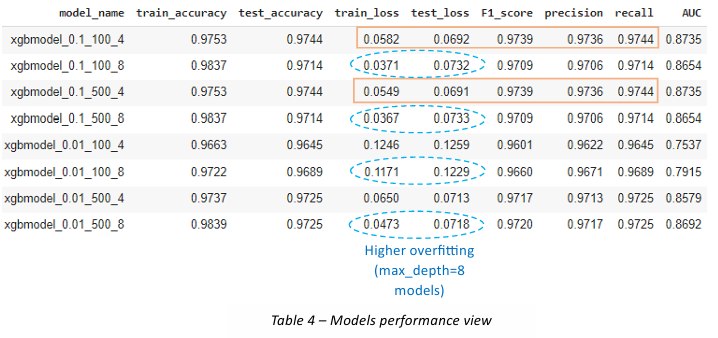

**Key insights** from models results include:  

- Lower max depth generally improves model fitting, while higher max depth leads to overfitting due to its complexity;

- Low learning rate and low estimators (models 5 0.01_100_4,  6 0.01_100_8) result in higher loss and underfitting due to slow learning and insufficient complexity.

#**Part 2.** Models insights

###**Features Importance - SHAP**

**💡** In this part of the analysis I am chosing the XGBoost baseline model results to generate **insights about our predicted churn group**. With the use of SHAP it is possible to obtain information about the **key drivers of churn** based on the models' results.

In [ ]:
shap.initjs()

shap_ex = shap.TreeExplainer(xgb_model)
vals = shap_ex(X_test)
vals_df = pd.DataFrame(vals.values, columns=X_test.columns, index=X_test.index)

**Checking for positive/negative contribution using SHAP values**

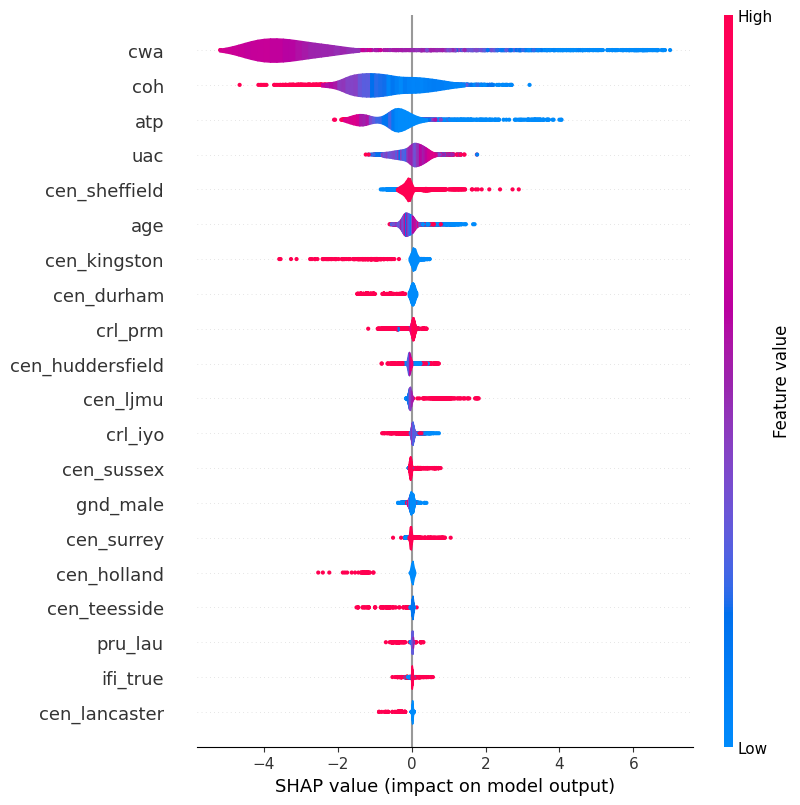

In [ ]:
shap.plots.violin(vals)

🔍 The top predictor is *Credit Weighted Average (cwa)*, where higher values correspond to lower SHAP scores, indicating a negative relationship with student dropout. *Contact Hours (coh) and Attendance Percentage (atp)* show similar trends.  

🔍 *Unauthorised Absence Count (uac)* is also a key factor but positively linked to dropout. *Centre names* like Sheffield and LJMU show a positive correlation with dropout, while Kingston and Durham trend negatively in SHAP values.

Here are a few different visuals of positive and negative predictors:

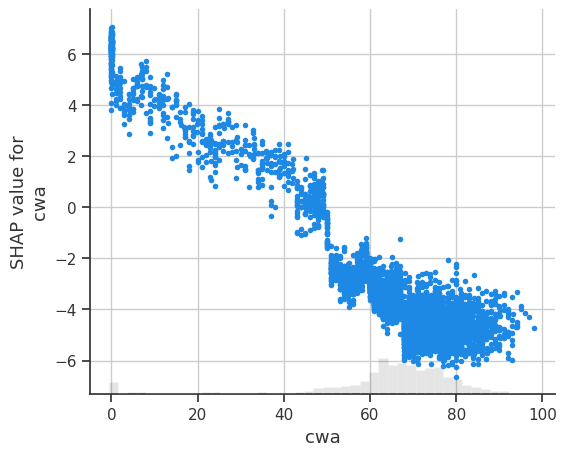

In [ ]:
shap.plots.scatter(vals[:, 'cwa'])

Lower likelyhood of drop out for higher credit weighted average (opposite trend).

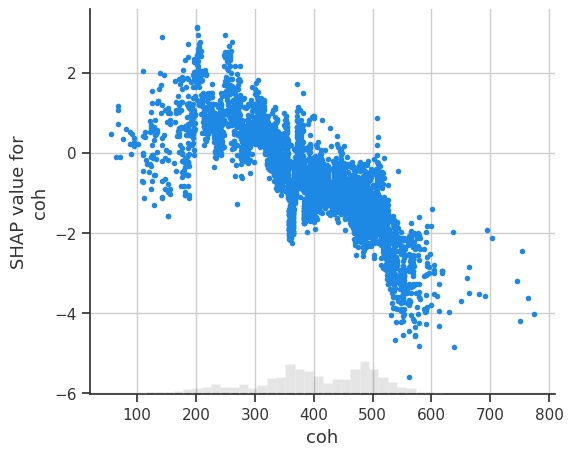

In [ ]:
shap.plots.scatter(vals[:, 'coh'])

Lower likelyhood of drop out for higher number of contact hours (opposite trend).

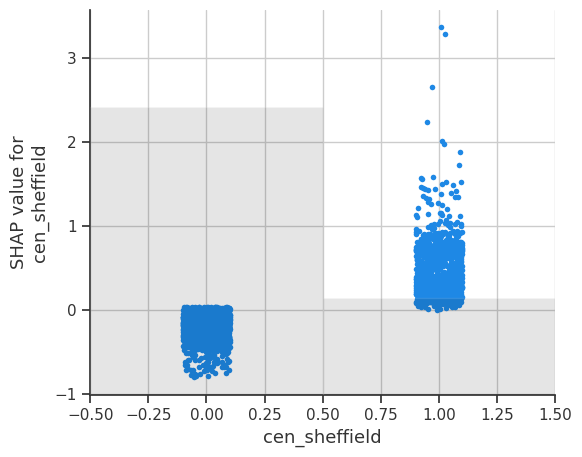

In [ ]:
shap.plots.scatter(vals[:, 'cen_sheffield'])

Higher likelyhood of dropout for Sheffield study centre.